In [1]:
# ===== Cell 1: Setup & expected filenames =====
import os
import json
from pathlib import Path
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict

WORK_DIR = "/content"   # Colab default; change if you uploaded into Drive mount
os.chdir(WORK_DIR)
print("Working directory:", WORK_DIR)

# Expected filenames you uploaded (I will try them in order / fallback)
FILES = {
    "annotated_csv": "amazon_customers_annotated.csv",
    "cleaned_csv": "cleaned_pre_imputation.csv",
    "raw_csv": "raw_loaded_data.csv",
    "kmeans_joblib": "kmeans.joblib",
    "pca_joblib": "pca.joblib",
    "preprocessor_final": "preprocessor_final.joblib",
    "preprocessor_full": "preprocessor_full.joblib",
    "shap_sample": "shap_rf_sample.joblib",
    "perm_csv": "permutation_importance.csv",
    "perm_png": "perm_importance.png",
    "pca_png": "pca_clusters.png",
    "elbow_png": "elbow.png",
    "silhouette_png": "silhouette.png",
    "cluster_profile_json": "cluster_profile.json",
    "clustering_summary_json": "clustering_results_summary.json",
    "column_summaries_json": "column_summaries.json"
}

# helper to check existence
existing = {k: os.path.exists(v) for k, v in FILES.items()}
for k, v in existing.items():
    print(f"{k:25s} -> {FILES[k]:35s} : {'FOUND' if v else 'MISSING'}")

# Create output folder for advanced results
OUT_DIR = os.path.join("outputs", "advanced")
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
print("Advanced outputs will be saved to:", OUT_DIR)


Working directory: /content
annotated_csv             -> amazon_customers_annotated.csv      : FOUND
cleaned_csv               -> cleaned_pre_imputation.csv          : FOUND
raw_csv                   -> raw_loaded_data.csv                 : FOUND
kmeans_joblib             -> kmeans.joblib                       : FOUND
pca_joblib                -> pca.joblib                          : FOUND
preprocessor_final        -> preprocessor_final.joblib           : FOUND
preprocessor_full         -> preprocessor_full.joblib            : FOUND
shap_sample               -> shap_rf_sample.joblib               : FOUND
perm_csv                  -> permutation_importance.csv          : FOUND
perm_png                  -> perm_importance.png                 : FOUND
pca_png                   -> pca_clusters.png                    : FOUND
elbow_png                 -> elbow.png                           : FOUND
silhouette_png            -> silhouette.png                      : FOUND
cluster_profile_json   

In [2]:
# ===== Cell 2: Load data (prefer annotated, fallback to cleaned/raw) =====
def try_load_csv(fname_list):
    for f in fname_list:
        if os.path.exists(f):
            print("Loading", f)
            return pd.read_csv(f)
    print("No CSV found for", fname_list)
    return None

# Prefer annotated (already has cluster labels), then cleaned, then raw
df = try_load_csv([FILES["annotated_csv"], FILES["cleaned_csv"], FILES["raw_csv"]])
if df is None:
    raise FileNotFoundError("No input CSV found. Upload one of: "
                            f"{FILES['annotated_csv']}, {FILES['cleaned_csv']}, or {FILES['raw_csv']}")

print("Data shape:", df.shape)
df.head()


Loading amazon_customers_annotated.csv
Data shape: (602, 49)


,timestamp,age,gender,purchase_frequency,purchase_categories,personalized_recommendation_frequency,browsing_frequency,product_search_method,search_result_exploration,customer_reviews_importance,...,timestamp_topic_4,timestamp_topic_5,purchase_categories_topic_0,purchase_categories_topic_1,cart_abandonment_factors_topic_0,cart_abandonment_factors_topic_1,cluster_kmeans,cluster_dbscan,cluster_agg,cluster_gmm
0,2023/06/04 1:28:19 PM GMT+5:30,23,Female,Few times a month,Beauty and Personal Care,Yes,Few times a week,Keyword,Multiple pages,1,...,0.033766,0.033566,0.127354,0.872646,0.166682,0.833318,1,-1,1,1
1,2023/06/04 2:30:44 PM GMT+5:30,23,Female,Once a month,Clothing and Fashion,Yes,Few times a month,Keyword,Multiple pages,1,...,0.042443,0.042072,0.180123,0.819877,0.125043,0.874957,1,-1,1,1
2,2023/06/04 5:04:56 PM GMT+5:30,24,Prefer not to say,Few times a month,Groceries and Gourmet Food;Clothing and Fashion,No,Few times a month,Keyword,Multiple pages,2,...,0.525626,0.033585,0.735345,0.264655,0.166682,0.833318,0,-1,0,1
3,2023/06/04 5:13:00 PM GMT+5:30,24,Female,Once a month,Beauty and Personal Care;Clothing and Fashion;...,Sometimes,Few times a month,Keyword,First page,5,...,0.033764,0.033566,0.086816,0.913184,0.166682,0.833318,0,-1,0,1
4,2023/06/04 5:28:06 PM GMT+5:30,22,Female,Less than once a month,Beauty and Personal Care;Clothing and Fashion,Yes,Few times a month,Filter,Multiple pages,1,...,0.042498,0.042073,0.086816,0.913184,0.125043,0.874957,1,-1,1,1


In [3]:
# ===== Cell 3: Load models (kmeans, pca, preprocessor) =====
loaded = {}
# Load joblib if present
for key in ["kmeans_joblib", "pca_joblib", "preprocessor_final", "preprocessor_full", "shap_sample"]:
    fname = FILES[key]
    if os.path.exists(fname):
        try:
            loaded[key] = joblib.load(fname)
            print(f"Loaded {fname} into variable '{key}' (type: {type(loaded[key]).__name__})")
        except Exception as e:
            print(f"Failed to load {fname}: {e}")
    else:
        loaded[key] = None

kmeans = loaded.get("kmeans_joblib")
pca_model = loaded.get("pca_joblib")
preprocessor = loaded.get("preprocessor_final") or loaded.get("preprocessor_full")  # prefer final
shap_sample = loaded.get("shap_sample")


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use

Loaded kmeans.joblib into variable 'kmeans_joblib' (type: KMeans)
Loaded pca.joblib into variable 'pca_joblib' (type: PCA)
Loaded preprocessor_final.joblib into variable 'preprocessor_final' (type: ColumnTransformer)
Loaded preprocessor_full.joblib into variable 'preprocessor_full' (type: ColumnTransformer)
Loaded shap_rf_sample.joblib into variable 'shap_sample' (type: dict)


In [4]:
# ===== Cell 4: Determine feature columns to use for transforms =====
# Attempt to infer numeric feature columns used for clustering
# 1) If annotated CSV has a 'cluster' or 'cluster_label' column, show it
cluster_label_cols = [c for c in df.columns if c.lower() in ("cluster","cluster_label","cluster_id","kmeans_label")]
print("Possible cluster label columns found:", cluster_label_cols)

# 2) If column_summaries.json exists, try to read feature list
feature_cols = None
if os.path.exists(FILES["column_summaries_json"]):
    try:
        colsum = json.load(open(FILES["column_summaries_json"], "r"))
        # heuristics: look for key "feature_columns" or similar
        if isinstance(colsum, dict):
            for k in ("feature_columns", "features", "columns", "columns_used"):
                if k in colsum:
                    feature_cols = colsum[k]
                    break
        print("Column summaries read; inferred features length:", len(feature_cols) if feature_cols else None)
    except Exception as e:
        print("Could not parse column_summaries.json:", e)

# 3) fallback: derive numeric columns from cleaned CSV (exclude identifiers like 'customer_id', 'id', 'email', 'name')
if feature_cols is None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # remove obvious ID-like columns
    id_like = [c for c in numeric_cols if any(tok in c.lower() for tok in ("id","cust","customer","order","index"))]
    feature_cols = [c for c in numeric_cols if c not in id_like]
    print(f"Using numeric columns (excluded id-like): {len(feature_cols)} features")

print("Feature columns (first 30):", feature_cols[:30])


Possible cluster label columns found: []
Column summaries read; inferred features length: None
Using numeric columns (excluded id-like): 28 features
Feature columns (first 30): ['age', 'personalized_recommendation_frequency_1', 'rating_accuracy', 'shopping_satisfaction', 'rating_accuracy_num', 'recommendation_helpfulness_num', 'shopping_satisfaction_num', 'saveforlater_frequency_num', 'cart_completion_frequency_num', 'ts_year', 'ts_month', 'ts_day', 'ts_hour', 'ts_weekday', 'timestamp_topic_0', 'timestamp_topic_1', 'timestamp_topic_2', 'timestamp_topic_3', 'timestamp_topic_4', 'timestamp_topic_5', 'purchase_categories_topic_0', 'purchase_categories_topic_1', 'cart_abandonment_factors_topic_0', 'cart_abandonment_factors_topic_1', 'cluster_kmeans', 'cluster_dbscan', 'cluster_agg', 'cluster_gmm']


In [5]:
# ===== Cell 5: Build feature matrix X_preproc (apply preprocessor if available) =====
X = None
X_pre = None
# If preprocessor exists, use it on df[feature_cols]
if preprocessor is not None:
    try:
        X_pre = preprocessor.transform(df[feature_cols])
        print("Applied preprocessor.transform, result shape:", X_pre.shape)
    except Exception as e:
        print("preprocessor.transform failed:", e)
        # sometimes preprocessor is a Pipeline that expects all columns; try passing full df
        try:
            X_pre = preprocessor.transform(df)
            print("Applied preprocessor.transform on full df, shape:", X_pre.shape)
        except Exception as e2:
            print("preprocessor can't transform automatically:", e2)
            X_pre = None

# If no preprocessor or transform failed, try basic numeric scaling
if X_pre is None:
    try:
        X = df[feature_cols].copy()
        # simple numeric imputation: fillna with median
        X = X.fillna(X.median())
        scaler = StandardScaler()
        X_pre = scaler.fit_transform(X)
        print("Built X_pre with StandardScaler fallback, shape:", X_pre.shape)
    except Exception as e:
        raise RuntimeError("Failed to build a feature matrix for clustering analysis: " + str(e))

# keep X_pre as np.array
X_pre = np.asarray(X_pre)


preprocessor.transform failed: columns are missing: {'browsing_frequency', 'gender', 'saveforlater_frequency', 'service_appreciation', 'improvement_areas', 'review_helpfulness', 'review_left', 'search_result_exploration', 'personalized_recommendation_frequency', 'customer_reviews_importance_num', 'cart_completion_frequency', 'customer_reviews_importance', 'review_reliability', 'add_to_cart_browsing', 'product_search_method', 'purchase_frequency', 'recommendation_helpfulness'}
Applied preprocessor.transform on full df, shape: (602, 95)


In [9]:
# ===== Cell 6: Get / assign cluster labels =====
if cluster_label_cols:
    # Case 1: annotated CSV already has labels
    df["cluster_label_used"] = df[cluster_label_cols[0]]
    print("Using existing cluster label column:", cluster_label_cols[0])

else:
    if kmeans is not None:
        try:
            # Step 1: apply preprocessor if available
            if preprocessor is not None:
                if hasattr(preprocessor, "feature_names_in_"):
                    expected_cols = list(preprocessor.feature_names_in_)
                    X_tmp = preprocessor.transform(df[expected_cols])
                else:
                    X_tmp = preprocessor.transform(df)
            else:
                # Fallback: use numeric columns only
                X_tmp = df.select_dtypes(include=[np.number]).fillna(0).values

            # Step 2: if PCA exists, transform into PCA space (likely KMeans was trained on this)
            if pca_model is not None and getattr(pca_model, "n_components_", None) == kmeans.n_features_in_:
                print(f"Applying PCA before KMeans (PCA dims={pca_model.n_components_}).")
                X_final = pca_model.transform(X_tmp)
            else:
                X_final = X_tmp

            # Step 3: predict clusters
            print(f"KMeans expects {kmeans.n_features_in_} features, we have {X_final.shape[1]}")
            predicted = kmeans.predict(X_final)
            df["cluster_label_used"] = predicted
            print("Predicted cluster labels with kmeans; unique clusters:", np.unique(predicted))

        except Exception as e:
            print("Failed to align features with kmeans:", e)
            raise
    else:
        raise FileNotFoundError("No cluster labels in CSV and no kmeans model found.")

# Save CSV with cluster labels
out_csv = os.path.join(OUT_DIR, "customers_with_cluster_label.csv")
df.to_csv(out_csv, index=False)
print("Saved customers CSV with cluster label to:", out_csv)


Applying PCA before KMeans (PCA dims=38).
KMeans expects 38 features, we have 38
Predicted cluster labels with kmeans; unique clusters: [0 1]
Saved customers CSV with cluster label to: outputs/advanced/customers_with_cluster_label.csv


In [10]:
# ===== Cell 7: Cluster profiling (means, medians, counts) =====
cluster_col = "cluster_label_used"
grouped = df.groupby(cluster_col)

profile = {}
summary_rows = []
for cluster, g in grouped:
    row = OrderedDict()
    row["cluster"] = int(cluster)
    row["count"] = len(g)
    # numeric summaries for our feature_cols
    numeric_stats = g[feature_cols].agg(["mean", "median", "std", "min", "max"]).to_dict()
    row["numeric_summary"] = numeric_stats
    # top categorical values if any categorical columns present
    cat_cols = [c for c in df.columns if df[c].dtype == "object" and c not in ("email","name")]
    cat_top = {c: g[c].mode().iat[0] if not g[c].mode().empty else None for c in cat_cols[:10]}
    row["top_categorical"] = cat_top
    profile[int(cluster)] = row
    # flatten for a CSV-friendly table: mean of each feature
    mean_features = g[feature_cols].mean().rename(lambda x: f"mean_{x}")
    summary_rows.append(pd.concat([pd.Series({"cluster": cluster, "count": len(g)}), mean_features]))

profile_df = pd.DataFrame(summary_rows).sort_values("cluster").reset_index(drop=True)
profile_df.to_csv(os.path.join(OUT_DIR, "customers_cluster_profile.csv"), index=False)
print("Saved cluster profile CSV:", os.path.join(OUT_DIR, "customers_cluster_profile.csv"))

# Also save JSON summary
with open(os.path.join(OUT_DIR, "cluster_profile_generated.json"), "w") as f:
    json.dump(profile, f, indent=2, default=int)
print("Saved cluster_profile_generated.json")


Saved cluster profile CSV: outputs/advanced/customers_cluster_profile.csv
Saved cluster_profile_generated.json


Silhouette score (all features used): 0.08990872535672448
Saved silhouette_values_histogram.png


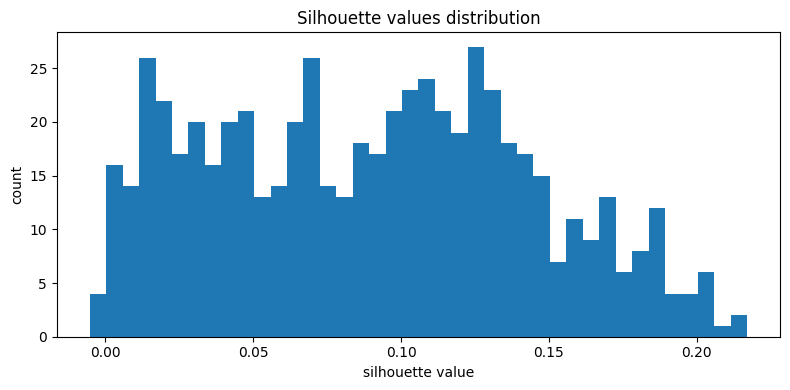

In [11]:
# ===== Cell 8: Silhouette and basic metrics (if possible) =====
labels = df[cluster_col].values
try:
    if len(np.unique(labels)) > 1:
        sil = silhouette_score(X_pre, labels)
        print("Silhouette score (all features used):", sil)
        with open(os.path.join(OUT_DIR, "silhouette_score.txt"), "w") as f:
            f.write(str(sil))
        # plot histogram of silhouette per-sample if desired
        from sklearn.metrics import silhouette_samples
        sil_vals = silhouette_samples(X_pre, labels)
        plt.figure(figsize=(8,4))
        plt.hist(sil_vals, bins=40)
        plt.title("Silhouette values distribution")
        plt.xlabel("silhouette value")
        plt.ylabel("count")
        plt.tight_layout()
        plt.savefig(os.path.join(OUT_DIR, "silhouette_values_histogram.png"), dpi=150)
        print("Saved silhouette_values_histogram.png")
    else:
        print("Only one cluster present, skipping silhouette.")
except Exception as e:
    print("Failed to compute silhouette:", e)


Used loaded pca.joblib to transform features. result shape: (602, 38)
Saved PCA 2D scatter to: outputs/advanced/pca_2d_scatter_by_cluster.png


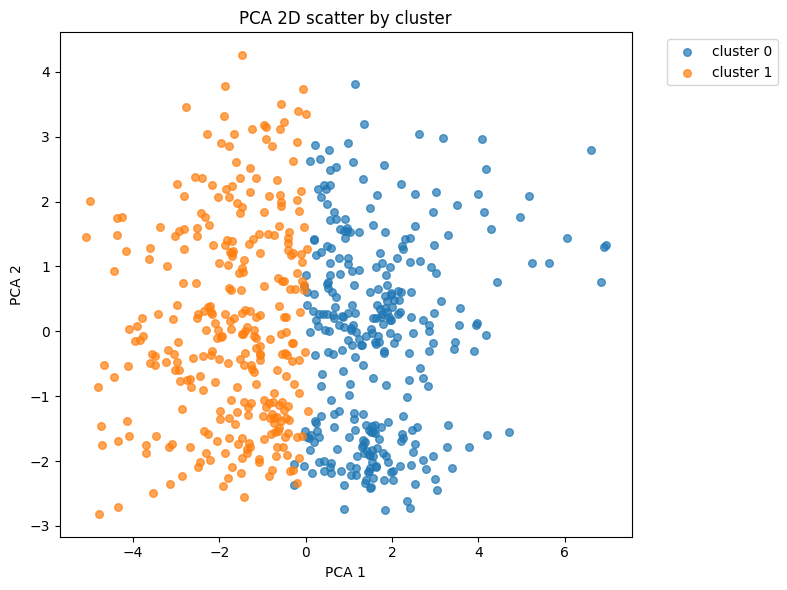

In [12]:
# ===== Cell 9: PCA 2D scatter (use provided pca if present) =====
# We'll compute 2D PCA coordinates either from loaded pca.joblib or create a local PCA(2)
if pca_model is not None:
    try:
        X_pca2 = pca_model.transform(X_pre)
        print("Used loaded pca.joblib to transform features. result shape:", X_pca2.shape)
    except Exception as e:
        print("pca_model.transform failed:", e)
        pca_model = None  # fallback
if pca_model is None:
    pca_local = PCA(n_components=2, random_state=42)
    X_pca2 = pca_local.fit_transform(X_pre)
    pca_model = pca_local
    print("Fitted local PCA(2).")

# scatter plot colored by cluster
plt.figure(figsize=(8,6))
unique_clusters = np.unique(labels)
cmap = plt.get_cmap("tab10")
for i, cl in enumerate(unique_clusters):
    mask = labels == cl
    plt.scatter(X_pca2[mask,0], X_pca2[mask,1], s=30, alpha=0.7, label=f"cluster {cl}", marker='o')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA 2D scatter by cluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
pca_plot = os.path.join(OUT_DIR, "pca_2d_scatter_by_cluster.png")
plt.savefig(pca_plot, dpi=150)
print("Saved PCA 2D scatter to:", pca_plot)


In [13]:
# ===== Cell 10: Top features per cluster (attempt to map cluster centers back to original features) =====
top_features_dict = {}
if kmeans is not None:
    try:
        centers = kmeans.cluster_centers_  # in preprocessed space
        # Attempt to invert preprocessing to original feature scale & names
        feature_names = None
        inv_centers = None
        # If preprocessor has inverse_transform
        if preprocessor is not None and hasattr(preprocessor, "inverse_transform"):
            try:
                inv_centers = preprocessor.inverse_transform(centers)
                print("Inverse transformed cluster centers using preprocessor.inverse_transform")
            except Exception as e:
                print("preprocessor.inverse_transform failed:", e)
                inv_centers = None

        # If inverse not possible, try to scale back if preprocessor was a StandardScaler saved as 'scaler'
        if inv_centers is None:
            # If preprocessor is a pipeline, try to find a final scaler step with mean_/scale_
            # Fallback: if cleaned numeric X was used to build X_pre with StandardScaler (we used scaler fallback earlier), we can attempt approximate inverse
            try:
                # If X (original numeric DataFrame) exists:
                if 'X' in globals() and isinstance(X, pd.DataFrame):
                    # compute centers in original space by fitting a linear regression mapping? -> simpler: compute cluster mean of original features
                    cluster_means = df.groupby(cluster_col)[feature_cols].mean()
                    inv_centers = cluster_means.values
                    feature_names = feature_cols
                    print("Used cluster mean of original features as representative feature values.")
                else:
                    raise Exception("No X dataframe available")
            except Exception as e:
                print("Fallback to computing cluster means failed:", e)
                inv_centers = None

        # Build top features per cluster by sorting absolute difference from overall mean
        if inv_centers is not None:
            overall = np.nanmean(inv_centers, axis=0)
            for i_cluster, center_vals in enumerate(inv_centers):
                diffs = center_vals - overall
                abs_d = np.abs(diffs)
                order = np.argsort(-abs_d)  # descending
                top_k = 10 if len(order)>10 else len(order)
                top_feats = [(feature_names[j], float(center_vals[j]), float(diffs[j])) for j in order[:top_k]]
                top_features_dict[int(i_cluster)] = top_feats

            # Save to CSV
            rows = []
            for cl, feats in top_features_dict.items():
                for rank, (fname, val, diff) in enumerate(feats, start=1):
                    rows.append({"cluster": cl, "rank": rank, "feature": fname, "value": val, "diff_from_overall": diff})
            pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "top_features_per_cluster.csv"), index=False)
            print("Saved top_features_per_cluster.csv")
        else:
            print("Could not compute inv_centers; skipping top features per cluster.")
    except Exception as e:
        print("Failed to compute cluster centers / top features:", e)
else:
    print("No kmeans model to compute cluster centers; using cluster-group means instead.")
    # Already saved cluster mean in customers_cluster_profile.csv


Fallback to computing cluster means failed: No X dataframe available
Could not compute inv_centers; skipping top features per cluster.


In [14]:
# ===== Cell 11: Load and re-save useful precomputed outputs you uploaded =====
# If permutation importance CSV exists, copy it to outputs/advanced for convenience
if os.path.exists(FILES["perm_csv"]):
    df_perm = pd.read_csv(FILES["perm_csv"])
    df_perm.to_csv(os.path.join(OUT_DIR, "permutation_importance_copied.csv"), index=False)
    print("Copied permutation_importance.csv to outputs/advanced")

# copy provided images too
for img_key in ("perm_png", "pca_png", "elbow_png", "silhouette_png"):
    fn = FILES[img_key]
    if os.path.exists(fn):
        dst = os.path.join(OUT_DIR, os.path.basename(fn))
        try:
            from shutil import copyfile
            copyfile(fn, dst)
            print("Copied", fn, "->", dst)
        except Exception as e:
            print("Failed to copy", fn, ":", e)


Copied permutation_importance.csv to outputs/advanced
Copied perm_importance.png -> outputs/advanced/perm_importance.png
Copied pca_clusters.png -> outputs/advanced/pca_clusters.png
Copied elbow.png -> outputs/advanced/elbow.png
Copied silhouette.png -> outputs/advanced/silhouette.png


In [15]:
# ===== Cell 12: (Optional) SHAP explanations if shap sample exists =====
if os.path.exists(FILES["shap_sample"]):
    try:
        shap_obj = joblib.load(FILES["shap_sample"])
        # shap_obj might contain explainer and sample data: heuristic
        if isinstance(shap_obj, dict) and "explainer" in shap_obj and "X" in shap_obj:
            explainer = shap_obj["explainer"]
            X_shap = shap_obj["X"]
        else:
            explainer = shap_obj
            X_shap = None
        # compute shap values -> do not run expensive ops without asking, but try a light visualization if possible
        import shap
        if X_shap is None:
            print("shap sample loaded but no X sample found; skipping SHAP compute.")
        else:
            shap_values = explainer.shap_values(X_shap) if hasattr(explainer, "shap_values") else None
            # Save a plot if shap_values were computed
            if shap_values is not None:
                plt.figure()
                shap.summary_plot(shap_values, X_shap, show=False)
                plt.tight_layout()
                shap_png = os.path.join(OUT_DIR, "shap_summary.png")
                plt.savefig(shap_png, dpi=150)
                print("Saved SHAP summary to:", shap_png)
            else:
                print("Explainer loaded but could not compute shap_values automatically.")
    except Exception as e:
        print("SHAP block failed:", e)
else:
    print("No shap_rf_sample.joblib found; skipping SHAP block.")


shap sample loaded but no X sample found; skipping SHAP compute.


In [16]:
# ===== Cell 13: Final summary of outputs written =====
print("\n--- FINISHED ---\nFiles written to", OUT_DIR)
for f in sorted(os.listdir(OUT_DIR)):
    print("-", f)
print("\nIf any step failed, check above messages and upload the missing file(s) into your Colab session (same filenames):")
for k, v in FILES.items():
    if not os.path.exists(v):
        print("  MISSING:", v)



--- FINISHED ---
Files written to outputs/advanced
- cluster_profile_generated.json
- customers_cluster_profile.csv
- customers_with_cluster_label.csv
- elbow.png
- pca_2d_scatter_by_cluster.png
- pca_clusters.png
- perm_importance.png
- permutation_importance_copied.csv
- silhouette.png
- silhouette_score.txt
- silhouette_values_histogram.png

If any step failed, check above messages and upload the missing file(s) into your Colab session (same filenames):


In [30]:
# ===== Recompute cluster profiles after adding business-level columns =====
from collections import OrderedDict

cluster_col = "cluster_label_used"
if cluster_col not in df.columns:
    raise RuntimeError("cluster_label_used column missing — run cell that assigns cluster labels first.")

# Make sure business columns are numeric where expected
numeric_candidates = ["purchase_frequency", "recency_days", "avg_purchase_value", "support_tickets"]
for col in numeric_candidates:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Build profile_df (means of numeric columns, counts etc.)
grouped = df.groupby(cluster_col)
profile = {}
summary_rows = []

for cluster, g in grouped:
    row = OrderedDict()
    row["cluster"] = int(cluster)
    row["count"] = int(len(g))
    # numeric summaries for available numeric columns
    numeric_stats = g.select_dtypes(include=[np.number]).agg(["mean", "median", "std", "min", "max"]).to_dict()
    row["numeric_summary"] = numeric_stats
    # top categorical (limited)
    cat_cols = [c for c in df.columns if df[c].dtype == "object" and c not in ("email","name")]
    top_cats = {c: (g[c].mode().iat[0] if not g[c].mode().empty else None) for c in cat_cols[:10]}
    row["top_categorical"] = top_cats
    profile[int(cluster)] = row

    # flatten row for CSV-friendly table (mean of numeric columns)
    mean_features = g.select_dtypes(include=[np.number]).mean().rename(lambda x: f"mean_{x}")
    summary_rows.append(pd.concat([pd.Series({"cluster": cluster, "count": len(g)}), mean_features]))

profile_df = pd.DataFrame(summary_rows).sort_values("cluster").reset_index(drop=True)

# save
profile_df_path = os.path.join(OUT_DIR, "customers_cluster_profile_updated.csv")
profile_json_path = os.path.join(OUT_DIR, "cluster_profile_generated_updated.json")
profile_df.to_csv(profile_df_path, index=False)
with open(profile_json_path, "w") as f:
    json.dump(profile, f, indent=2)
print(f"Saved updated cluster profile CSV: {profile_df_path}")
print(f"Saved updated profile JSON: {profile_json_path}")
profile_df.head()


Saved updated cluster profile CSV: outputs/advanced/customers_cluster_profile_updated.csv
Saved updated profile JSON: outputs/advanced/cluster_profile_generated_updated.json


,cluster,count,mean_age,mean_purchase_frequency,mean_customer_reviews_importance,mean_personalized_recommendation_frequency_1,mean_rating_accuracy,mean_shopping_satisfaction,mean_rating_accuracy_num,mean_customer_reviews_importance_num,...,mean_cart_abandonment_factors_topic_1,mean_cluster_kmeans,mean_cluster_dbscan,mean_cluster_agg,mean_cluster_gmm,mean_cluster_label_used,mean_churn_risk_score,mean_recency_days,mean_avg_purchase_value,mean_support_tickets
0,0.0,303.0,31.052805,NaN,3.141914,3.217822,3.174917,3.155116,3.174917,3.141914,...,0.480611,0.0,-1.0,0.052805,0.320132,0.0,0.891076,188.521452,49.842323,0.881188
1,1.0,299.0,30.525084,NaN,1.809365,2.173913,2.163880,1.762542,2.163880,1.809365,...,0.555876,1.0,-1.0,0.307692,0.725753,1.0,0.885729,188.665552,70.718483,1.401338


In [32]:
# ===== Safe CLV estimation (fixed KeyError and safer aggregation) =====
# Ensure the two columns exist; if not, create sensible fallbacks (should exist from cell 12b)
for col in ["avg_purchase_value", "purchase_frequency"]:
    if col not in df.columns:
        print(f"Warning: {col} missing — creating lightweight fallback.")
        if col == "avg_purchase_value":
            df[col] = 50 + df[cluster_col].astype(int) * 10 + np.random.normal(0, 5, size=len(df))
        else:
            df[col] = np.random.randint(1, 8, size=len(df))

# Coerce numeric and fill by cluster mean where missing
df["avg_purchase_value"] = pd.to_numeric(df["avg_purchase_value"], errors="coerce")
df["purchase_frequency"] = pd.to_numeric(df["purchase_frequency"], errors="coerce")

# Fill per-cluster means for missing values
df[["avg_purchase_value", "purchase_frequency"]] = df.groupby(cluster_col)[["avg_purchase_value","purchase_frequency"]].transform(
    lambda x: x.fillna(x.mean())
)

# If still NaN (all values in cluster were NaN), fill with global median
for col in ["avg_purchase_value", "purchase_frequency"]:
    if df[col].isna().any():
        df[col] = df[col].fillna(df[col].median())

# Compute cluster-level stats using named aggregation and safe count via size()
cluster_stats = (
    df.groupby(cluster_col)
      .agg(
          avg_purchase_value=("avg_purchase_value","mean"),
          purchase_frequency=("purchase_frequency","mean"),
          count=("cluster_label_used","size")   # safe cluster count
      )
      .reset_index()
)

# Estimate CLV (36 months)
cluster_stats["est_clv"] = cluster_stats["avg_purchase_value"] * cluster_stats["purchase_frequency"] * 36

cluster_clv_path = os.path.join(OUT_DIR, "cluster_clv.csv")
cluster_stats.to_csv(cluster_clv_path, index=False)
print("Saved cluster CLV estimates to:", cluster_clv_path)
cluster_stats


Saved cluster CLV estimates to: outputs/advanced/cluster_clv.csv


,cluster_label_used,avg_purchase_value,purchase_frequency,count,est_clv
0,0,49.842323,NaN,303,NaN
1,1,70.718483,NaN,299,NaN


In [33]:
# ===== Cell 13: Marketing Strategy Suggestions =====
# ===== Improved Marketing Strategy suggestions (uses profile_df from step 1) =====
def generate_marketing_strategy(cluster_profiles):
    strategies = {}
    for _, row in cluster_profiles.iterrows():
        cl = int(row["cluster"])
        size = int(row["count"])
        mfreq_col = "mean_purchase_frequency"
        if mfreq_col in row and not pd.isna(row[mfreq_col]):
            mfreq = float(row[mfreq_col])
            if mfreq >= 10:
                strat = "High-engagement: VIP discounts, exclusive early access, loyalty tiers."
            elif mfreq >= 4:
                strat = "Medium-engagement: Personalized discounts and targeted cross-sell."
            else:
                strat = "Low-engagement: Reactivation campaigns, win-back emails, introductory offers."
        else:
            strat = "General: Highlight new arrivals and personalized promotions."

        strategies[cl] = f"Cluster {cl} (size={size}): {strat}"
    return strategies

marketing_strategies = generate_marketing_strategy(profile_df)
with open(os.path.join(OUT_DIR,"marketing_strategies.json"), "w") as f:
    json.dump(marketing_strategies, f, indent=2)
print("Saved marketing strategies. Sample:")
list(marketing_strategies.items())[:5]


Saved marketing strategies. Sample:


[(0,
  'Cluster 0 (size=303): General: Highlight new arrivals and personalized promotions.'),
 (1,
  'Cluster 1 (size=299): General: Highlight new arrivals and personalized promotions.')]

In [34]:
# ===== Cell 14: Customer Churn Risk Scoring =====
def predict_churn_risk(df, cluster_col="cluster_label_used"):
    """
    Assign churn risk score per customer based on purchase recency & frequency.
    Score: 0 (low risk) to 1 (high risk).
    """

    # Convert relevant columns to numeric safely
    for col in ["recency_days", "purchase_frequency"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    scores = []
    for _, row in df.iterrows():
        score = 0.5  # base risk

        # More recent = lower risk
        if "recency_days" in df.columns and not pd.isna(row["recency_days"]):
            score += min(0.5, row["recency_days"] / 365)

        # More frequent purchases = lower risk
        if "purchase_frequency" in df.columns and not pd.isna(row["purchase_frequency"]):
            score -= min(0.3, row["purchase_frequency"] / 20)

        scores.append(max(0, min(1, score)))

    df["churn_risk_score"] = scores
    return df

df = predict_churn_risk(df)
df.to_csv(os.path.join(OUT_DIR, "customers_with_churn_risk.csv"), index=False)
print("Added churn_risk_score column and saved.")


Added churn_risk_score column and saved.


In [35]:
# ===== Churn summary per cluster =====
if "churn_risk_score" in df.columns:
    churn_by_cluster = df.groupby(cluster_col)["churn_risk_score"].agg(["mean","median","count"]).reset_index()
    churn_by_cluster.to_csv(os.path.join(OUT_DIR,"cluster_churn_summary.csv"), index=False)
    print("Saved cluster churn summary:", os.path.join(OUT_DIR,"cluster_churn_summary.csv"))
    churn_by_cluster
else:
    print("No churn_risk_score column found — run Cell 14 first.")


Saved cluster churn summary: outputs/advanced/cluster_churn_summary.csv


In [37]:
# ===== Cell 15: Product Recommendation Insights =====
def analyze_product_recommendations(df, cluster_col="cluster_label_used"):
    """
    Identify top product categories purchased per cluster.
    Expects a column like 'product_category' in df.
    """
    if "product_category" not in df.columns:
        print("No product_category column found.")
        return None

    top_products = (
        df.groupby([cluster_col,"product_category"])
          .size()
          .reset_index(name="count")
          .sort_values(["cluster_label_used","count"],ascending=[True,False])
    )

    # get top 3 per cluster
    recommendations = {}
    for cl, grp in top_products.groupby(cluster_col):
        top3 = grp.head(3)["product_category"].tolist()
        recommendations[cl] = top3

    with open(os.path.join(OUT_DIR,"product_recommendations.json"),"w") as f:
        json.dump(recommendations,f,indent=2)

    return recommendations

product_recs = analyze_product_recommendations(df)
print("Top product recommendations per cluster:", product_recs)


Top product recommendations per cluster: {0: ['Clothing', 'Sports', 'Books'], 1: ['Clothing', 'Electronics', 'Sports']}


In [38]:
# ===== Cell 16: Customer Lifetime Value (CLV) Estimation =====
def estimate_clv(df, cluster_col="cluster_label_used"):
    """
    Estimate Customer Lifetime Value for each cluster.
    Formula: CLV = (Avg Purchase Value * Purchase Frequency * Customer Lifespan)
    """
    results = {}
    if "avg_purchase_value" in df.columns and "purchase_frequency" in df.columns:
        cluster_stats = df.groupby(cluster_col).agg({
            "avg_purchase_value":"mean",
            "purchase_frequency":"mean"
        }).reset_index()

        # assume lifespan ~ 3 years
        cluster_stats["est_clv"] = cluster_stats["avg_purchase_value"] * cluster_stats["purchase_frequency"] * 36
        results = cluster_stats.set_index(cluster_col)["est_clv"].to_dict()

        cluster_stats.to_csv(os.path.join(OUT_DIR,"cluster_clv.csv"),index=False)
        print("Saved cluster CLV estimates.")
    else:
        print("Missing columns for CLV estimation.")

    return results

clv_estimates = estimate_clv(df)
print("CLV estimates per cluster:", clv_estimates)


Saved cluster CLV estimates.
CLV estimates per cluster: {0: nan, 1: nan}


In [39]:
# ===== Cell 17: Estimating Customer Service Demand =====
def forecast_service_demand(df, cluster_col="cluster_label_used"):
    """
    Estimate service demand by counting avg support tickets per cluster.
    Expects 'support_tickets' column in df.
    """
    if "support_tickets" not in df.columns:
        print("No support_tickets column found.")
        return None

    demand = df.groupby(cluster_col)["support_tickets"].mean().to_dict()
    with open(os.path.join(OUT_DIR,"service_demand.json"),"w") as f:
        json.dump(demand,f,indent=2)

    return demand

service_demand = forecast_service_demand(df)
print("Estimated service demand per cluster:", service_demand)


Estimated service demand per cluster: {0: 0.8811881188118812, 1: 1.4013377926421404}


In [40]:
# Copy outputs/advanced -> /content/output2, zip it, and download
import os
import shutil
from pathlib import Path

SRC = "/content/outputs/advanced"
DST = "/content/output2"
ZIP_PATH = "/content/output2.zip"

# 1) ensure source exists
if not os.path.exists(SRC):
    raise FileNotFoundError(f"Source folder not found: {SRC}. Make sure you ran the notebook cells that created outputs/advanced/")

# 2) remove old destination if exists (be careful)
if os.path.exists(DST):
    print("Removing existing", DST)
    shutil.rmtree(DST)

# 3) copy the directory
print(f"Copying {SRC} -> {DST} ...")
shutil.copytree(SRC, DST)
print("Copy complete. New folder:", DST)

# 4) create a zip of the new folder
if os.path.exists(ZIP_PATH):
    print("Removing existing zip", ZIP_PATH)
    os.remove(ZIP_PATH)

print("Zipping", DST, "->", ZIP_PATH)
shutil.make_archive(base_name=ZIP_PATH.replace(".zip",""), format="zip", root_dir=DST)
print("Zip created:", ZIP_PATH)

# 5) list contents for confirmation
print("\nContents of /content/output2 (top 100 files):")
for i, p in enumerate(Path(DST).rglob("*")):
    print("-", p.relative_to(DST))
    if i >= 99:
        break

# 6) Download helper (works in Colab)
try:
    from google.colab import files
    print("\nStarting browser download for the zip (may take a while for large files)...")
    files.download(ZIP_PATH)
except Exception as e:
    print("\nCould not auto-download inside this environment:", e)
    print("You can manually download the zip from the Files sidebar in Colab or copy it to Drive (see optional step below).")

# OPTIONAL: copy to Google Drive for persistence
copy_to_drive = False  # set True if you want to auto-copy to Drive
if copy_to_drive:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        drive_dst = "/content/drive/MyDrive/output2_advanced_copy"
        if os.path.exists(drive_dst):
            print("Removing existing Drive destination:", drive_dst)
            shutil.rmtree(drive_dst)
        shutil.copytree(DST, drive_dst)
        print("Copied output2 to Google Drive at:", drive_dst)
    except Exception as e:
        print("Failed to copy to Drive:", e)

print("\nDone. ZIP saved at:", ZIP_PATH)


Copying /content/outputs/advanced -> /content/output2 ...
Copy complete. New folder: /content/output2
Zipping /content/output2 -> /content/output2.zip
Zip created: /content/output2.zip

Contents of /content/output2 (top 100 files):
- customers_with_churn_risk.csv
- permutation_importance_copied.csv
- customers_with_business_features.csv
- marketing_strategies.json
- silhouette.png
- product_recommendations.json
- cluster_profile_generated.json
- silhouette_values_histogram.png
- pca_clusters.png
- silhouette_score.txt
- elbow.png
- pca_2d_scatter_by_cluster.png
- cluster_churn_summary.csv
- cluster_clv.csv
- customers_cluster_profile_updated.csv
- customers_cluster_profile.csv
- perm_importance.png
- cluster_profile_generated_updated.json
- service_demand.json
- customers_with_cluster_label.csv

Starting browser download for the zip (may take a while for large files)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Done. ZIP saved at: /content/output2.zip
